In [1]:
import matplotlib.pyplot as plt

import sys
import os

import numpy as np

from PIL import Image, ImageSequence
import cv2

from matplotlib.pyplot import imshow

from glob import glob
from matplotlib import pyplot
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam

In [ ]:
from ipywidgets import interact
import ipywidgets as widgets

In [ ]:
def loadImages(directory="../dataset", size=(64, 64)):
    """
        Loads the images from the directory
            
        Paramters:
            * directory : The dataset directory
                - Default directory : ./dataset
            * size : The size of the images imported
                - Default size      : 64 x 64
        
        Return:
            image: list of (array of) images loaded from directory
        
    """
    images = list()
    
    root = list(os.walk(directory))[0][0]
    imagePaths = list(map(lambda x: os.path.join(root, x), list(os.walk(directory))[0][2]))
    
    for path in imagePaths:
        path = path.replace("\\", "/")
        
        image = cv2.imread(path)
        image = cv2.resize(image, size)
        
        images.append((cv2.cvtColor(image, cv2.COLOR_BGR2RGB)-127.5) / 127.5)
        
    return np.array(images)

In [ ]:
images = loadImages(size=(128, 128))

In [ ]:
def displayImages(offset = 0):
    """
        Displays the images from the images list using matplotlib.pyplot function imshow
        
        Parameter:
            * offset : A number between 0 to 25632 to set the select of 25 images to be displayed
                - Default offset : 0
    """
    
    dim=(5, 5)
    _, ax = plt.subplots(dim[0], dim[1], figsize = (10, 10))

    for i in range(dim[0]):
        for j in range(dim[1]):
            ax[i, j].imshow(images[offset+5*i+j]*0.5 + 0.5)
            ax[i, j].axis('off')

In [ ]:
interact(displayImages, offset=widgets.IntSlider(value=0, min=0, max=25632, step=1))

In [2]:
IMG_H = 128
IMG_W = 128
IMG_C = 3 
w_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

In [3]:
## Hyperparameters
batch_size = 128
latent_dim = 128
num_epochs = 1000
images_path = glob("../dataset/*")

In [4]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img)
    img = tf.image.resize_with_crop_or_pad(img, IMG_H, IMG_W)
    img = tf.cast(img, tf.float32)
    img = (img - 127.5) / 127.5
    return img

def tf_dataset(images_path, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(images_path)
    dataset = dataset.shuffle(buffer_size=10240)
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

def deconv_block(inputs, num_filters, kernel_size, strides, bn=True):
    x = Conv2DTranspose(
        filters=num_filters,
        kernel_size=kernel_size,
        kernel_initializer=w_init,
        padding="same",
        strides=strides,
        use_bias=False
        )(inputs)

    if bn:
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
    return x

def conv_block(inputs, num_filters, kernel_size, padding="same", strides=2, activation=True):
    x = Conv2D(
        filters=num_filters,
        kernel_size=kernel_size,
        kernel_initializer=w_init,
        padding=padding,
        strides=strides,
    )(inputs)

    if activation:
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(0.3)(x)
    return x

In [5]:
def build_generator(latent_dim):
    f = [2**i for i in range(5)][::-1]
    filters = 32
    output_strides = 16
    h_output = IMG_H // output_strides
    w_output = IMG_W // output_strides

    noise = Input(shape=(latent_dim,), name="generator_noise_input")

    x = Dense(f[0] * filters * h_output * w_output, use_bias=False)(noise)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Reshape((h_output, w_output, 16 * filters))(x)

    for i in range(1, 5):
        x = deconv_block(x,
            num_filters=f[i] * filters,
            kernel_size=5,
            strides=2,
            bn=True
        )

    x = conv_block(x,
        num_filters=3,  ## Change this to 1 for grayscale.
        kernel_size=5,
        strides=1,
        activation=False
    )
    fake_output = Activation("tanh")(x)

    return Model(noise, fake_output, name="generator")

def build_discriminator():
    f = [2**i for i in range(4)]
    image_input = Input(shape=(IMG_H, IMG_W, IMG_C))
    x = image_input
    filters = 64
    output_strides = 16
    h_output = IMG_H // output_strides
    w_output = IMG_W // output_strides

    for i in range(0, 4):
        x = conv_block(x, num_filters=f[i] * filters, kernel_size=5, strides=2)

    x = Flatten()(x)
    x = Dense(1)(x)

    return Model(image_input, x, name="discriminator")

In [6]:
class GAN(Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        for _ in range(2):
            ## Train the discriminator
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            generated_images = self.generator(random_latent_vectors)
            generated_labels = tf.zeros((batch_size, 1))

            with tf.GradientTape() as ftape:
                predictions = self.discriminator(generated_images)
                d1_loss = self.loss_fn(generated_labels, predictions)
            grads = ftape.gradient(d1_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

            ## Train the discriminator
            labels = tf.ones((batch_size, 1))

            with tf.GradientTape() as rtape:
                predictions = self.discriminator(real_images)
                d2_loss = self.loss_fn(labels, predictions)
            grads = rtape.gradient(d2_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        ## Train the generator
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.ones((batch_size, 1))

        with tf.GradientTape() as gtape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = gtape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {"d1_loss": d1_loss, "d2_loss": d2_loss, "g_loss": g_loss}

In [7]:
def save_plot(examples, epoch, n):
    examples = (examples + 1) / 2.0
    
    
    fig, axs = plt.subplots(5,5, figsize = (8,8))

    for i in range(5):
        for j in range(5):
            axs[i,j].imshow(examples[5*i+j])
            axs[i,j].axis('off')

    fig.savefig(f"../OutputAnime/Faces_{epoch:0>5}.png")
    plt.close()

In [ ]:
if __name__ == "__main__":
    print(len(images_path))  #25663
    
    epochsDone =int(open("./epochCount.txt").read())+1
    
    d_model = build_discriminator()
    g_model = build_generator(latent_dim)

    d_model.load_weights("../saved_model/d_model.h5")
    g_model.load_weights("../saved_model/g_model.h5")

    d_model.summary()
    g_model.summary()

    gan = GAN(d_model, g_model, latent_dim)

    bce_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.1)
    d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    gan.compile(d_optimizer, g_optimizer, bce_loss_fn)

    images_dataset = tf_dataset(images_path, batch_size)

    for epoch in range(epochsDone, num_epochs):
        gan.fit(images_dataset, epochs=1)
        g_model.save("../saved_model/g_model.h5")
        d_model.save("../saved_model/d_model.h5")

        n_samples = 25
        noise = np.random.normal(size=(n_samples, latent_dim))
        examples = g_model.predict(noise)
        save_plot(examples, epoch, int(np.sqrt(n_samples)))
        
        with open("./epochCount.txt", "w") as f:
            f.write(str(epochsDone))

25663
Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 64)        0         
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       204928    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 128

### Generate new images

In [2]:
model = load_model("../saved_model/g_model.h5")

In [15]:
noise = np.random.normal(-1, 1, size=(25, 128))

In [16]:
fake = model.predict(noise)

In [17]:
def displayImages(fake):
    """
        Displays the images from the images list using matplotlib.pyplot function imshow
    """
    
    dim=(5, 5)
    _, ax = plt.subplots(dim[0], dim[1], figsize = (10, 10))

    for i in range(dim[0]):
        for j in range(dim[1]):
            ax[i, j].imshow((fake[5*i+j]+1)/2)
            ax[i, j].axis('off')

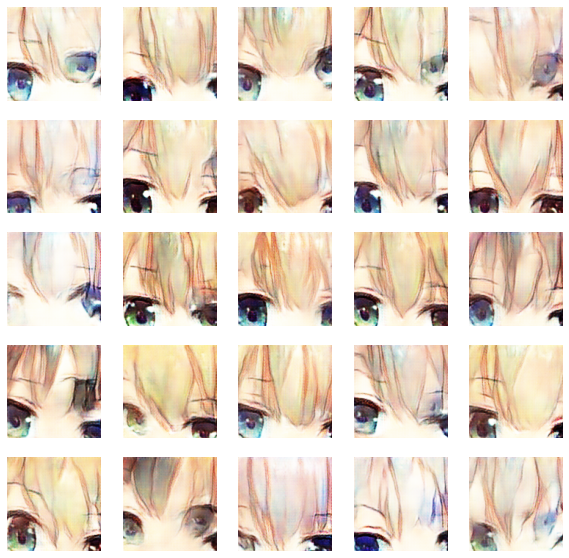

In [18]:
displayImages(fake)

<hr>

In [81]:
import glob
from PIL import Image

In [92]:
def makeGif(frame_folder):
    frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.png")]
    frame_one = frames[0]
    frame_one.save("../output.gif", format="GIF", append_images=frames,
               save_all=True, duration=500, loop=0)

In [93]:
makeGif("../OutputAnime")

![](../output.gif)

In [3]:
epoch = int(open("./epochCount.txt").read())+1

In [4]:
epoch

35